<a href="https://colab.research.google.com/github/haryoa/note_music_generator/blob/master/MusicGeneratorPianoColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0-alpha0 

import tensorflow as tf
from tensorflow.keras import backend as K
import glob
import random
import pretty_midi
import IPython
import numpy as np
from tqdm import tnrange, tqdm_notebook, tqdm
from random import shuffle, seed
import numpy as np
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Nadam
import numpy as np
from numpy.random import choice
import pickle
import matplotlib.pyplot as plt

import unicodedata
import re
import numpy as np
import os
import io
import time

def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


In [0]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v1.0.0/maestro-v1.0.0-midi.zip

In [0]:
!unzip maestro-v1.0.0-midi.zip

--2019-03-24 05:29:05--  https://storage.googleapis.com/magentadata/datasets/maestro/v1.0.0/maestro-v1.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 2a00:1450:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46579421 (44M) [application/zip]
Saving to: ‘maestro-v1.0.0-midi.zip’

maestro-v1.0.0-midi 100%[===================>]  44.42M  35.9MB/s    in 1.2s    

2019-03-24 05:29:06 (35.9 MB/s) - ‘maestro-v1.0.0-midi.zip’ saved [46579421/46579421]



# Get All Midi Files

In [0]:
def get_list_midi(folder = 'maestro-v1.0.0/**/*.midi', seed_int = 666):
  """Get the list of all midi file in the folders
  
  Parameters
  ==========
  folder : str
    The midi folder.
  seed_int : int
    the random seed.
  
  Returns
  =======
  The midi files
  
  """
  list_all_midi = glob.glob(folder)
  seed(seed_int)
  shuffle(list_all_midi)
  return list_all_midi

list_all_midi = get_list_midi()

# Prepare some functions
See its documentation to see the function

In [0]:
class NoteTokenizer:
    
    def __init__(self):
      self.notes_to_index = {}
      self.index_to_notes = {}
      self.num_of_word = 0
      self.unique_word = 0
      self.notes_freq = {}
        
    def transform(self,list_array):
      """ Transform a list of note in string into index.
      
      Parameters
      ==========
      list_array : list
        list of note in string format
      
      Returns
      =======
      The transformed list in numpy array.
      
      """
      transformed_list = []
      for instance in list_array:
          transformed_list.append([self.notes_to_index[note] for note in instance])
      return np.array(transformed_list, dtype=np.int32)
 
    def partial_fit(self, notes):
        """ Partial fit on the dictionary of the tokenizer
        
        Parameters
        ==========
        notes : list of notes
        
        """
        for note in notes:
            note_str = ','.join(str(a) for a in note)
            if note_str in self.notes_freq:
                self.notes_freq[note_str] += 1
                self.num_of_word += 1
            else:
                self.notes_freq[note_str] = 1
                self.unique_word += 1
                self.num_of_word += 1
                self.notes_to_index[note_str], self.index_to_notes[self.unique_word] = self.unique_word, note_str
            
    def add_new_note(self, note):
        """ Add a new note into the dictionary

        Parameters
        ==========
        note : str
          a new note who is not in dictionary.  

        """
        assert note not in self.notes_to_index
        self.unique_word += 1
        self.notes_to_index[note], self.index_to_notes[self.unique_word] = self.unique_word, note
        
def generate_batch_song(list_all_midi, batch_music=16, start_index=0, fs=30, seq_len=50, use_tqdm=False):
    """
    Generate Batch music that will be used to be input and output of the neural network
    
    Parameters
    ==========
    list_all_midi : list
      List of midi files
    batch_music : int
      A number of music in one batch
    start_index : int
      The start index to be batched in list_all_midi
    fs : int
      Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    seq_len : int
      The sequence length of the music to be input of neural network
    use_tqdm : bool
      Whether to use tqdm or not in the function
    
    Returns
    =======
    Tuple of input and target neural network
    
    """
    
    assert len(list_all_midi) >= batch_music
    dict_time_notes = generate_dict_time_notes(list_all_midi, batch_music, start_index, fs, use_tqdm=use_tqdm)
    
    list_musics = process_notes_in_song(dict_time_notes, seq_len)
    collected_list_input, collected_list_target = [], []
     
    for music in list_musics:
        list_training, list_target = generate_input_and_target(music, seq_len)
        collected_list_input += list_training
        collected_list_target += list_target
    return collected_list_input, collected_list_target

def generate_dict_time_notes(list_all_midi, batch_song = 16, start_index=0, fs=30, use_tqdm=True):
    """ Generate map (dictionary) of music ( in index ) to piano_roll (in np.array)

    Parameters
    ==========
    list_all_midi : list
        List of midi files
    batch_music : int
      A number of music in one batch
    start_index : int
      The start index to be batched in list_all_midi
    fs : int
      Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    use_tqdm : bool
      Whether to use tqdm or not in the function

    Returns
    =======
    dictionary of music to piano_roll (in np.array)

    """
    assert len(list_all_midi) >= batch_song
    
    dict_time_notes = {}
    process_tqdm_midi = tqdm_notebook(range(start_index, min(start_index + batch_song, len(list_all_midi)))) if use_tqdm else range(start_index,  min(start_index + batch_song, len(list_all_midi)))
    for i in process_tqdm_midi:
        midi_file_name = list_all_midi[i]
        if use_tqdm:
            process_tqdm_midi.set_description("Processing {}".format(midi_file_name))
        try: # Handle exception on malformat MIDI files
            midi_pretty_format = pretty_midi.PrettyMIDI(midi_file_name)
            piano_midi = midi_pretty_format.instruments[0] # Get the piano channels
            piano_roll = piano_midi.get_piano_roll(fs=fs)
            dict_time_notes[i] = piano_roll
        except Exception as e:
            print(e)
            print("broken file : {}".format(midi_file_name))
            pass
    return dict_time_notes

def generate_input_and_target(dict_keys_time, seq_len=50):
    """ Generate input and the target of our deep learning for one music.
    
    Parameters
    ==========
    dict_keys_time : dict
      Dictionary of timestep and notes
    seq_len : int
      The length of the sequence
      
    Returns
    =======
    Tuple of list of input and list of target of neural network.
    
       
    """
    # Get the start time and end time
    start_time, end_time = list(dict_keys_time.keys())[0], list(dict_keys_time.keys())[-1]
    list_training, list_target = [], []
    for index_enum, time in enumerate(range(start_time, end_time)):
        list_append_training, list_append_target = [], []
        start_iterate = 0
        flag_target_append = False # flag to append the test list
        if index_enum < seq_len:
            start_iterate = seq_len - index_enum - 1
            for i in range(start_iterate): # add 'e' to the seq list. 
                list_append_training.append('e')
                flag_target_append = True

        for i in range(start_iterate,seq_len):
            index_enum = time - (seq_len - i - 1)
            if index_enum in dict_keys_time:
                list_append_training.append(','.join(str(x) for x in dict_keys_time[index_enum]))      
            else:
                list_append_training.append('e')

        # add time + 1 to the list_append_target
        if time+1 in dict_keys_time:
            list_append_target.append(','.join(str(x) for x in dict_keys_time[time+1]))
        else:
            list_append_target.append('e')
        list_training.append(list_append_training)
        list_target.append(list_append_target)
    return list_training, list_target

def process_notes_in_song(dict_time_notes, seq_len = 50):
    """
    Iterate the dict of piano rolls into dictionary of timesteps and note played
    
    Parameters
    ==========
    dict_time_notes : dict
      dict contains index of music ( in index ) to piano_roll (in np.array)
    seq_len : int
      Length of the sequence
      
    Returns
    =======
    Dict of timesteps and note played
    """
    list_of_dict_keys_time = []
    
    for key in dict_time_notes:
        sample = dict_time_notes[key]
        times = np.unique(np.where(sample > 0)[1])
        index = np.where(sample > 0)
        dict_keys_time = {}

        for time in times:
            index_where = np.where(index[1] == time)
            notes = index[0][index_where]
            dict_keys_time[time] = notes
        list_of_dict_keys_time.append(dict_keys_time)
    return list_of_dict_keys_time



# Sample 100 midi files from the datasets
These midi files will be used to train the neural network

In [0]:
# Get 200 midis file from the datasets.. 

sampled_200_midi = list_all_midi[0:100]  

We create a map of note -> index here using NoteTokenizer that we've defined before.  
This object will be used to transform the list of notes to be ready for the input of Neural Network

In [0]:
batch = 1
start_index = 0
note_tokenizer = NoteTokenizer()

for i in tqdm_notebook(range(len(sampled_200_midi))):
    dict_time_notes = generate_dict_time_notes(sampled_200_midi, batch_song=1, start_index=i, use_tqdm=False, fs=5)
    full_notes = process_notes_in_song(dict_time_notes)
    for note in full_notes:
        note_tokenizer.partial_fit(list(note.values()))
   

In [0]:
note_tokenizer.add_new_note('e') # Add empty notes

In [0]:
unique_notes = note_tokenizer.unique_word
print(unique_notes)

36010


# Make Architecture
Now we will make the architecture.. 
We will try to make the architecture as follow:
1. Embedding
2. LSTM
3. Self Head Attention
4. LSTM
5. Self Head Attention
6. Dense

In [0]:
seq_len = 50
EPOCHS = 4
BATCH_SONG = 16
BATCH_NNET_SIZE = 96
TOTAL_SONGS = len(sampled_200_midi)
FRAME_PER_SECOND = 5


We will use the code from here for self-attention  
https://github.com/CyberZHG/keras-self-attention/blob/master/keras_self_attention/seq_self_attention.py

In [0]:
class SeqSelfAttention(tf.keras.layers.Layer):

    ATTENTION_TYPE_ADD = 'additive'
    ATTENTION_TYPE_MUL = 'multiplicative'

    def __init__(self,
                 units=32,
                 attention_width=None,
                 attention_type=ATTENTION_TYPE_ADD,
                 return_attention=False,
                 history_only=False,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 use_additive_bias=True,
                 use_attention_bias=True,
                 attention_activation=None,
                 attention_regularizer_weight=0.0,
                 **kwargs):
        """Layer initialization.
        For additive attention, see: https://arxiv.org/pdf/1806.01264.pdf
        :param units: The dimension of the vectors that used to calculate the attention weights.
        :param attention_width: The width of local attention.
        :param attention_type: 'additive' or 'multiplicative'.
        :param return_attention: Whether to return the attention weights for visualization.
        :param history_only: Only use historical pieces of data.
        :param kernel_initializer: The initializer for weight matrices.
        :param bias_initializer: The initializer for biases.
        :param kernel_regularizer: The regularization for weight matrices.
        :param bias_regularizer: The regularization for biases.
        :param kernel_constraint: The constraint for weight matrices.
        :param bias_constraint: The constraint for biases.
        :param use_additive_bias: Whether to use bias while calculating the relevance of inputs features
                                  in additive mode.
        :param use_attention_bias: Whether to use bias while calculating the weights of attention.
        :param attention_activation: The activation used for calculating the weights of attention.
        :param attention_regularizer_weight: The weights of attention regularizer.
        :param kwargs: Parameters for parent class.
        """
        self.supports_masking = True
        self.units = units
        self.attention_width = attention_width
        self.attention_type = attention_type
        self.return_attention = return_attention
        self.history_only = history_only
        if history_only and attention_width is None:
            self.attention_width = int(1e9)

        self.use_additive_bias = use_additive_bias
        self.use_attention_bias = use_attention_bias
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = tf.keras.constraints.get(kernel_constraint)
        self.bias_constraint = tf.keras.constraints.get(bias_constraint)
        self.attention_activation = tf.keras.activations.get(attention_activation)
        self.attention_regularizer_weight = attention_regularizer_weight
        self._backend = tf.keras.backend.backend()

        if attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self.Wx, self.Wt, self.bh = None, None, None
            self.Wa, self.ba = None, None
        elif attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self.Wa, self.ba = None, None
        else:
            raise NotImplementedError('No implementation for attention type : ' + attention_type)

        super(SeqSelfAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'attention_width': self.attention_width,
            'attention_type': self.attention_type,
            'return_attention': self.return_attention,
            'history_only': self.history_only,
            'use_additive_bias': self.use_additive_bias,
            'use_attention_bias': self.use_attention_bias,
            'kernel_initializer': tf.keras.regularizers.serialize(self.kernel_initializer),
            'bias_initializer': tf.keras.regularizers.serialize(self.bias_initializer),
            'kernel_regularizer': tf.keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': tf.keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': tf.keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': tf.keras.constraints.serialize(self.bias_constraint),
            'attention_activation': tf.keras.activations.serialize(self.attention_activation),
            'attention_regularizer_weight': self.attention_regularizer_weight,
        }
        base_config = super(SeqSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self._build_additive_attention(input_shape)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self._build_multiplicative_attention(input_shape)
        super(SeqSelfAttention, self).build(input_shape)

    def _build_additive_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wt = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wt'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        self.Wx = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wx'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_additive_bias:
            self.bh = self.add_weight(shape=(self.units,),
                                      name='{}_Add_bh'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

        self.Wa = self.add_weight(shape=(self.units, 1),
                                  name='{}_Add_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Add_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def _build_multiplicative_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wa = self.add_weight(shape=(feature_dim, feature_dim),
                                  name='{}_Mul_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Mul_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def call(self, inputs, mask=None, **kwargs):
        if isinstance(inputs, list):
            inputs, positions = inputs
            positions = K.cast(positions, 'int32')
            mask = mask[1]
        else:
            positions = None

        input_len = K.shape(inputs)[1]

        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            e = self._call_additive_emission(inputs)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            e = self._call_multiplicative_emission(inputs)

        if self.attention_activation is not None:
            e = self.attention_activation(e)
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.attention_width is not None:
            ones = tf.ones((input_len, input_len))
            if self.history_only:
                local = tf.linalg.band_part(
                    ones,
                    K.minimum(input_len, self.attention_width - 1),
                    0,
                )
            else:
                local = tf.linalg.band_part(
                    ones,
                    K.minimum(input_len, self.attention_width // 2),
                    K.minimum(input_len, (self.attention_width - 1) // 2),
                )
            e = e * K.expand_dims(local, 0)
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            e = K.permute_dimensions(K.permute_dimensions(e * mask, (0, 2, 1)) * mask, (0, 2, 1))

        # a_{t} = \text{softmax}(e_t)
        s = K.sum(e, axis=-1)
        s = K.tile(K.expand_dims(s, axis=-1), K.stack([1, 1, input_len]))
        a = e / (s + K.epsilon())

        # l_t = \sum_{t'} a_{t, t'} x_{t'}
        v = K.batch_dot(a, inputs)
        if self.attention_regularizer_weight > 0.0:
            self.add_loss(self._attention_regularizer(a))

        if positions is not None:
            pos_num = K.shape(positions)[1]
            batch_indices = K.tile(K.expand_dims(K.arange(K.shape(inputs)[0]), axis=-1), K.stack([1, pos_num]))
            pos_indices = K.stack([batch_indices, positions], axis=-1)
            v = tf.gather_nd(v, pos_indices)
            a = tf.gather_nd(a, pos_indices)

        if self.return_attention:
            return [v, a]
        return v

    def _call_additive_emission(self, inputs):
        input_shape = K.shape(inputs)
        batch_size, input_len = input_shape[0], input_shape[1]

        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q, k = K.dot(inputs, self.Wt), K.dot(inputs, self.Wx)
        q = K.tile(K.expand_dims(q, 2), K.stack([1, 1, input_len, 1]))
        k = K.tile(K.expand_dims(k, 1), K.stack([1, input_len, 1, 1]))
        if self.use_additive_bias:
            h = K.tanh(q + k + self.bh)
        else:
            h = K.tanh(q + k)

        # e_{t, t'} = W_a h_{t, t'} + b_a
        if self.use_attention_bias:
            e = K.reshape(K.dot(h, self.Wa) + self.ba, (batch_size, input_len, input_len))
        else:
            e = K.reshape(K.dot(h, self.Wa), (batch_size, input_len, input_len))
        return e

    def _call_multiplicative_emission(self, inputs):
        # e_{t, t'} = x_t^T W_a x_{t'} + b_a
        e = K.batch_dot(K.dot(inputs, self.Wa), K.permute_dimensions(inputs, (0, 2, 1)))
        if self.use_attention_bias:
            e = e + self.ba
        return e

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape, pos_shape = input_shape
            output_shape = (input_shape[0], pos_shape[1], input_shape[2])
        else:
            output_shape = input_shape
        if self.return_attention:
            attention_shape = (input_shape[0], output_shape[1], input_shape[1])
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(inputs, list):
            mask = mask[1]
        if self.return_attention:
            return [mask, None]
        return mask

    def _attention_regularizer(self, attention):
        batch_size = K.cast(K.shape(attention)[0], K.floatx())
        input_len = K.shape(attention)[-1]
        return self.attention_regularizer_weight * K.sum(K.square(K.batch_dot(
            attention,
            K.permute_dimensions(attention, (0, 2, 1))) - tf.eye(input_len))) / batch_size

    @staticmethod
    def get_custom_objects():
      return {'SeqSelfAttention': SeqSelfAttention}

In [0]:
def create_model(seq_len, unique_notes, dropout=0.3, output_emb=100, rnn_unit=128, dense_unit=64):
  inputs = tf.keras.layers.Input(shape=(seq_len,))
  embedding = tf.keras.layers.Embedding(input_dim=unique_notes+1, output_dim=output_emb, input_length=seq_len)(inputs)
  forward_pass = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_unit, return_sequences=True))(embedding)
  forward_pass , att_vector = SeqSelfAttention(
      return_attention=True,
      attention_activation='sigmoid', 
      attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
      attention_width=50, 
      kernel_regularizer=tf.keras.regularizers.l2(1e-4),
      bias_regularizer=tf.keras.regularizers.l1(1e-4),
      attention_regularizer_weight=1e-4,
  )(forward_pass)
  forward_pass = tf.keras.layers.Dropout(dropout)(forward_pass)
  forward_pass = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_unit, return_sequences=True))(forward_pass)
  forward_pass , att_vector2 = SeqSelfAttention(
      return_attention=True,
      attention_activation='sigmoid', 
      attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
      attention_width=50, 
      kernel_regularizer=tf.keras.regularizers.l2(1e-4),
      bias_regularizer=tf.keras.regularizers.l1(1e-4),
      attention_regularizer_weight=1e-4,
  )(forward_pass)
  forward_pass = tf.keras.layers.Dropout(dropout)(forward_pass)
  forward_pass = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_unit))(forward_pass)
  forward_pass = tf.keras.layers.Dropout(dropout)(forward_pass)
  forward_pass = tf.keras.layers.Dense(dense_unit)(forward_pass)
  forward_pass = tf.keras.layers.LeakyReLU()(forward_pass)
  outputs = tf.keras.layers.Dense(unique_notes+1, activation = "softmax")(forward_pass)

  model = tf.keras.Model(inputs=inputs, outputs=outputs, name='generate_scores_rnn')
  return model

model = create_model(seq_len, unique_notes)

In [0]:
model.summary()

Model: "generate_scores_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 100)           3601100   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           176640    
_________________________________________________________________
seq_self_attention (SeqSelfA [(None, 50, 256), (None,  65537     
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           296448    
_________________________________________________________________
seq_self_attention_1 (SeqSel [(None, 50, 256), 

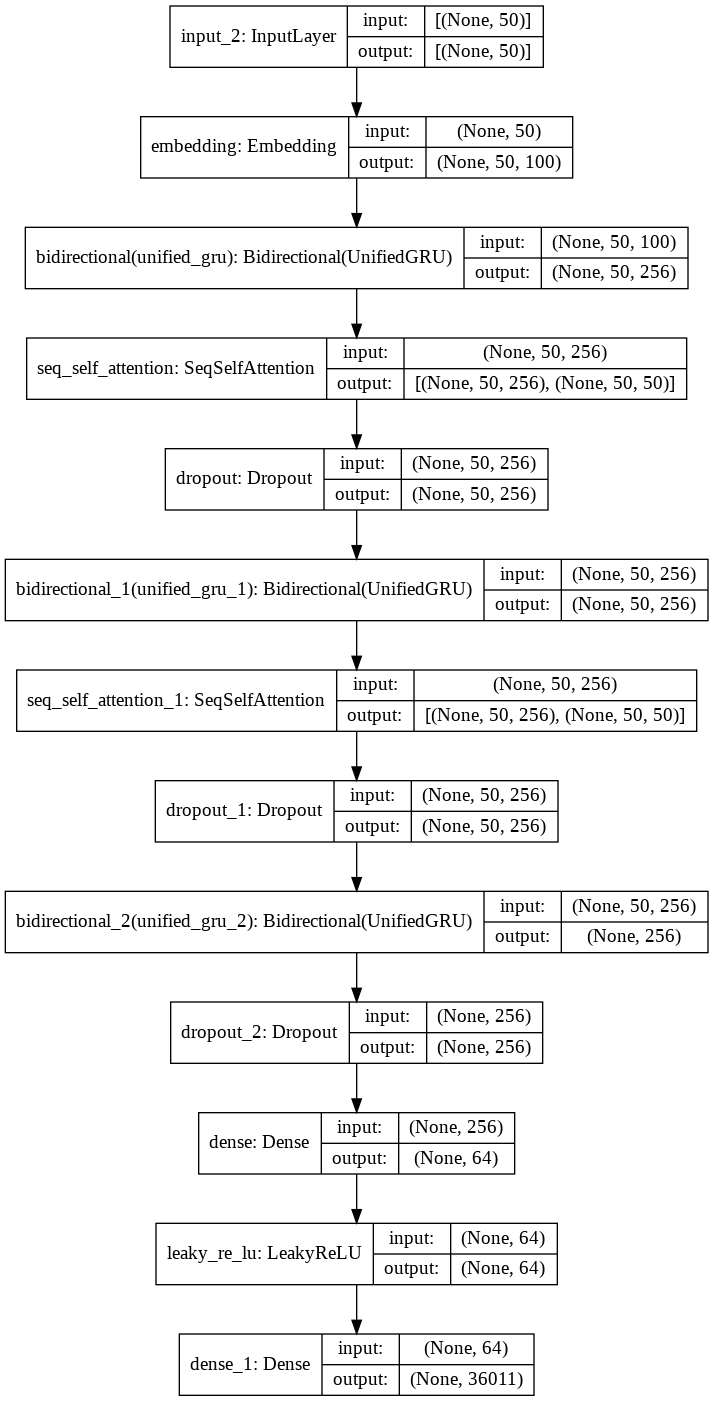

In [0]:
tf.keras.utils.plot_model(model, 'this_model.png', show_shapes=True)

# Train

In [0]:
import os
optimizer = Nadam()

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
loss_fn = sparse_categorical_crossentropy


In [0]:
class TrainModel:
  
  def __init__(self, epochs, note_tokenizer, sampled_200_midi, frame_per_second, 
               batch_nnet_size, batch_song, optimizer, checkpoint, loss_fn,
               checkpoint_prefix, total_songs, model):
    self.epochs = epochs
    self.note_tokenizer = note_tokenizer
    self.sampled_200_midi = sampled_200_midi
    self.frame_per_second = frame_per_second
    self.batch_nnet_size = batch_nnet_size
    self.batch_song = batch_song
    self.optimizer = optimizer
    self.checkpoint = checkpoint
    self.loss_fn = loss_fn
    self.checkpoint_prefix = checkpoint_prefix
    self.total_songs = total_songs
    self.model = model
    
  def train(self):
    for epoch in tqdm_notebook(range(self.epochs),desc='epochs'):
      # for each epochs, we shufle the list of all the datasets
      shuffle(self.sampled_200_midi)
      loss_total = 0
      steps = 0
      steps_nnet = 0

      # We will iterate all songs by self.song_size
      for i in tqdm_notebook(range(0,self.total_songs, self.batch_song), desc='MUSIC'):

        steps += 1
        inputs_nnet_large, outputs_nnet_large = generate_batch_song(
            self.sampled_200_midi, self.batch_song, start_index=i, fs=self.frame_per_second, 
            seq_len=seq_len, use_tqdm=False) # We use the function that have been defined here
        inputs_nnet_large = np.array(self.note_tokenizer.transform(inputs_nnet_large), dtype=np.int32)
        outputs_nnet_large = np.array(self.note_tokenizer.transform(outputs_nnet_large), dtype=np.int32)

        index_shuffled = np.arange(start=0, stop=len(inputs_nnet_large))
        np.random.shuffle(index_shuffled)

        for nnet_steps in tqdm_notebook(range(0,len(index_shuffled),self.batch_nnet_size)):
          steps_nnet += 1
          current_index = index_shuffled[nnet_steps:nnet_steps+self.batch_nnet_size]
          inputs_nnet, outputs_nnet = inputs_nnet_large[current_index], outputs_nnet_large[current_index]
          
          # To make sure no exception thrown by tensorflow on autograph
          if len(inputs_nnet) // self.batch_nnet_size != 1:
            break
          loss = self.train_step(inputs_nnet, outputs_nnet)
          loss_total += tf.math.reduce_sum(loss)
          if steps_nnet % 20 == 0:
            print("epochs {} | Steps {} | total loss : {}".format(epoch + 1, steps_nnet, loss_total))

      checkpoint.save(file_prefix = self.checkpoint_prefix)
  
  @tf.function
  def train_step(self, inputs, targets):
    with tf.GradientTape() as tape:
      prediction = self.model(inputs)
      loss = self.loss_fn(targets, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    return loss

# Train Here
Beware that the time of one epoch is around 1 hour.

In [0]:
seq_len = 50
EPOCHS = 4
BATCH_SONG = 16
BATCH_NNET_SIZE = 96
TOTAL_SONGS = len(sampled_200_midi)
FRAME_PER_SECOND = 5

train_class = TrainModel(EPOCHS, note_tokenizer, sampled_200_midi, FRAME_PER_SECOND,
                  BATCH_NNET_SIZE, BATCH_SONG, optimizer, checkpoint, loss_fn,
                  checkpoint_prefix, TOTAL_SONGS, model)

train_class.train()

epochs 1 | Steps 20 | total loss : 16656.767578125
epochs 1 | Steps 40 | total loss : 31536.435546875
epochs 1 | Steps 60 | total loss : 46286.66796875
epochs 1 | Steps 80 | total loss : 60721.1796875
epochs 1 | Steps 100 | total loss : 75227.53125
epochs 1 | Steps 120 | total loss : 89674.5546875
epochs 1 | Steps 140 | total loss : 103842.0859375
epochs 1 | Steps 160 | total loss : 117878.1015625
epochs 1 | Steps 180 | total loss : 131858.5625
epochs 1 | Steps 200 | total loss : 145829.734375
epochs 1 | Steps 220 | total loss : 159837.21875
epochs 1 | Steps 240 | total loss : 173747.078125
epochs 1 | Steps 260 | total loss : 187585.3125
epochs 1 | Steps 280 | total loss : 201283.3125
epochs 1 | Steps 300 | total loss : 214985.625
epochs 1 | Steps 320 | total loss : 229075.09375
epochs 1 | Steps 340 | total loss : 242902.953125


epochs 1 | Steps 360 | total loss : 256287.703125
epochs 1 | Steps 380 | total loss : 270774.125
epochs 1 | Steps 400 | total loss : 284773.65625
epochs 1 | Steps 420 | total loss : 299062.4375
epochs 1 | Steps 440 | total loss : 313249.0625
epochs 1 | Steps 460 | total loss : 327028.1875
epochs 1 | Steps 480 | total loss : 340881.46875
epochs 1 | Steps 500 | total loss : 354709.3125
epochs 1 | Steps 520 | total loss : 368794.21875
epochs 1 | Steps 540 | total loss : 382827.28125
epochs 1 | Steps 560 | total loss : 396328.84375
epochs 1 | Steps 580 | total loss : 409777.875
epochs 1 | Steps 600 | total loss : 423199.53125
epochs 1 | Steps 620 | total loss : 436739.03125
epochs 1 | Steps 640 | total loss : 450177.8125
epochs 1 | Steps 660 | total loss : 463348.625
epochs 1 | Steps 680 | total loss : 476357.5625
epochs 1 | Steps 700 | total loss : 489605.0625
epochs 1 | Steps 720 | total loss : 502904.15625
epochs 1 | Steps 740 | total loss : 516086.03125
epochs 1 | Steps 760 | total los

epochs 1 | Steps 880 | total loss : 607607.125
epochs 1 | Steps 900 | total loss : 621603.5625
epochs 1 | Steps 920 | total loss : 635695.1875
epochs 1 | Steps 940 | total loss : 649459.75
epochs 1 | Steps 960 | total loss : 663107.5
epochs 1 | Steps 980 | total loss : 676671.0625
epochs 1 | Steps 1000 | total loss : 690050.125
epochs 1 | Steps 1020 | total loss : 703618.6875
epochs 1 | Steps 1040 | total loss : 716845.375
epochs 1 | Steps 1060 | total loss : 730406.75
epochs 1 | Steps 1080 | total loss : 743496.125
epochs 1 | Steps 1100 | total loss : 756347.5
epochs 1 | Steps 1120 | total loss : 769531.5
epochs 1 | Steps 1140 | total loss : 782556.8125
epochs 1 | Steps 1160 | total loss : 795770.25
epochs 1 | Steps 1180 | total loss : 808693.8125
epochs 1 | Steps 1200 | total loss : 821257.1875
epochs 1 | Steps 1220 | total loss : 833841.1875
epochs 1 | Steps 1240 | total loss : 846677.3125
epochs 1 | Steps 1260 | total loss : 859356.1875
epochs 1 | Steps 1280 | total loss : 872155.1

epochs 1 | Steps 1380 | total loss : 935819.9375
epochs 1 | Steps 1400 | total loss : 950811.875
epochs 1 | Steps 1420 | total loss : 965572.5
epochs 1 | Steps 1440 | total loss : 979826.25
epochs 1 | Steps 1460 | total loss : 994501.3125
epochs 1 | Steps 1480 | total loss : 1009152.3125
epochs 1 | Steps 1500 | total loss : 1023582.8125
epochs 1 | Steps 1520 | total loss : 1038181.9375
epochs 1 | Steps 1540 | total loss : 1051998.5
epochs 1 | Steps 1560 | total loss : 1066061.875
epochs 1 | Steps 1580 | total loss : 1080297.75
epochs 1 | Steps 1600 | total loss : 1094255.0
epochs 1 | Steps 1620 | total loss : 1108223.5
epochs 1 | Steps 1640 | total loss : 1122228.0
epochs 1 | Steps 1660 | total loss : 1135780.5
epochs 1 | Steps 1680 | total loss : 1149682.0
epochs 1 | Steps 1700 | total loss : 1163712.25
epochs 1 | Steps 1720 | total loss : 1177536.625
epochs 1 | Steps 1740 | total loss : 1191061.5
epochs 1 | Steps 1760 | total loss : 1204757.875
epochs 1 | Steps 1780 | total loss : 12

epochs 1 | Steps 1860 | total loss : 1271568.125
epochs 1 | Steps 1880 | total loss : 1285107.375
epochs 1 | Steps 1900 | total loss : 1298386.625
epochs 1 | Steps 1920 | total loss : 1311601.125
epochs 1 | Steps 1940 | total loss : 1324973.125
epochs 1 | Steps 1960 | total loss : 1338249.0
epochs 1 | Steps 1980 | total loss : 1351634.75
epochs 1 | Steps 2000 | total loss : 1364749.125
epochs 1 | Steps 2020 | total loss : 1377898.375
epochs 1 | Steps 2040 | total loss : 1390563.375
epochs 1 | Steps 2060 | total loss : 1403634.25
epochs 1 | Steps 2080 | total loss : 1416376.75
epochs 1 | Steps 2100 | total loss : 1429656.75
epochs 1 | Steps 2120 | total loss : 1442512.375
epochs 1 | Steps 2140 | total loss : 1455243.125
epochs 1 | Steps 2160 | total loss : 1468205.75
epochs 1 | Steps 2180 | total loss : 1480898.75
epochs 1 | Steps 2200 | total loss : 1493547.625


epochs 1 | Steps 2220 | total loss : 1505869.75
epochs 1 | Steps 2240 | total loss : 1518827.0
epochs 1 | Steps 2260 | total loss : 1531820.875
epochs 1 | Steps 2280 | total loss : 1544682.625
epochs 1 | Steps 2300 | total loss : 1557655.625
epochs 1 | Steps 2320 | total loss : 1570517.5
epochs 1 | Steps 2340 | total loss : 1583365.125
epochs 1 | Steps 2360 | total loss : 1596092.25
epochs 1 | Steps 2380 | total loss : 1608521.75
epochs 1 | Steps 2400 | total loss : 1621059.25
epochs 1 | Steps 2420 | total loss : 1633470.25
epochs 1 | Steps 2440 | total loss : 1645565.25
epochs 1 | Steps 2460 | total loss : 1657924.5
epochs 1 | Steps 2480 | total loss : 1670134.5
epochs 1 | Steps 2500 | total loss : 1682647.25
epochs 1 | Steps 2520 | total loss : 1694948.875
epochs 1 | Steps 2540 | total loss : 1707366.125
epochs 1 | Steps 2560 | total loss : 1719439.25
epochs 1 | Steps 2580 | total loss : 1731717.625
epochs 1 | Steps 2600 | total loss : 1743673.125


epochs 1 | Steps 2620 | total loss : 1756460.0
epochs 1 | Steps 2640 | total loss : 1769903.125
epochs 1 | Steps 2660 | total loss : 1782968.125
epochs 1 | Steps 2680 | total loss : 1795677.5
epochs 1 | Steps 2700 | total loss : 1808276.875


epochs 2 | Steps 20 | total loss : 12915.67578125
epochs 2 | Steps 40 | total loss : 25246.71875
epochs 2 | Steps 60 | total loss : 37314.79296875
epochs 2 | Steps 80 | total loss : 49414.83203125
epochs 2 | Steps 100 | total loss : 61877.484375
epochs 2 | Steps 120 | total loss : 73974.6796875
epochs 2 | Steps 140 | total loss : 85959.4453125
epochs 2 | Steps 160 | total loss : 97790.8828125
epochs 2 | Steps 180 | total loss : 109829.6328125
epochs 2 | Steps 200 | total loss : 121515.8046875
epochs 2 | Steps 220 | total loss : 133584.625
epochs 2 | Steps 240 | total loss : 145425.296875
epochs 2 | Steps 260 | total loss : 157405.125
epochs 2 | Steps 280 | total loss : 169127.171875
epochs 2 | Steps 300 | total loss : 180820.3125
epochs 2 | Steps 320 | total loss : 192317.546875
epochs 2 | Steps 340 | total loss : 203853.203125
epochs 2 | Steps 360 | total loss : 215202.75
epochs 2 | Steps 380 | total loss : 226724.234375
epochs 2 | Steps 400 | total loss : 238146.359375
epochs 2 | Ste

epochs 2 | Steps 620 | total loss : 363345.25
epochs 2 | Steps 640 | total loss : 375990.875
epochs 2 | Steps 660 | total loss : 388179.34375
epochs 2 | Steps 680 | total loss : 400196.78125
epochs 2 | Steps 700 | total loss : 412533.125
epochs 2 | Steps 720 | total loss : 424786.5625
epochs 2 | Steps 740 | total loss : 436982.84375
epochs 2 | Steps 760 | total loss : 448775.78125
epochs 2 | Steps 780 | total loss : 460575.625
epochs 2 | Steps 800 | total loss : 472402.40625
epochs 2 | Steps 820 | total loss : 484212.65625
epochs 2 | Steps 840 | total loss : 495339.53125
epochs 2 | Steps 860 | total loss : 506724.125
epochs 2 | Steps 880 | total loss : 518171.65625
epochs 2 | Steps 900 | total loss : 529807.375
epochs 2 | Steps 920 | total loss : 541258.5625
epochs 2 | Steps 940 | total loss : 552877.5625
epochs 2 | Steps 960 | total loss : 564734.8125
epochs 2 | Steps 980 | total loss : 576229.5
epochs 2 | Steps 1000 | total loss : 587473.25
epochs 2 | Steps 1020 | total loss : 598787

epochs 2 | Steps 1060 | total loss : 621087.0
epochs 2 | Steps 1080 | total loss : 633101.8125
epochs 2 | Steps 1100 | total loss : 644739.1875
epochs 2 | Steps 1120 | total loss : 656887.6875
epochs 2 | Steps 1140 | total loss : 668499.625
epochs 2 | Steps 1160 | total loss : 680206.625
epochs 2 | Steps 1180 | total loss : 691982.875
epochs 2 | Steps 1200 | total loss : 703624.625
epochs 2 | Steps 1220 | total loss : 715186.25
epochs 2 | Steps 1240 | total loss : 726202.875
epochs 2 | Steps 1260 | total loss : 737354.9375
epochs 2 | Steps 1280 | total loss : 748564.4375
epochs 2 | Steps 1300 | total loss : 759890.375
epochs 2 | Steps 1320 | total loss : 771251.6875
epochs 2 | Steps 1340 | total loss : 782720.0625
epochs 2 | Steps 1360 | total loss : 793858.0625
epochs 2 | Steps 1380 | total loss : 804973.75
epochs 2 | Steps 1400 | total loss : 815901.5
epochs 2 | Steps 1420 | total loss : 826916.5
epochs 2 | Steps 1440 | total loss : 837700.8125
epochs 2 | Steps 1460 | total loss : 84

epochs 2 | Steps 1500 | total loss : 870840.625
epochs 2 | Steps 1520 | total loss : 883214.0
epochs 2 | Steps 1540 | total loss : 895301.5625
epochs 2 | Steps 1560 | total loss : 907411.75
epochs 2 | Steps 1580 | total loss : 919406.0625
epochs 2 | Steps 1600 | total loss : 931451.1875
epochs 2 | Steps 1620 | total loss : 943234.375
epochs 2 | Steps 1640 | total loss : 954845.25
epochs 2 | Steps 1660 | total loss : 966691.1875
epochs 2 | Steps 1680 | total loss : 978241.9375
epochs 2 | Steps 1700 | total loss : 989910.625
epochs 2 | Steps 1720 | total loss : 1001316.9375
epochs 2 | Steps 1740 | total loss : 1013085.4375
epochs 2 | Steps 1760 | total loss : 1024621.875
epochs 2 | Steps 1780 | total loss : 1035747.0625
epochs 2 | Steps 1800 | total loss : 1047068.25
epochs 2 | Steps 1820 | total loss : 1058217.125
epochs 2 | Steps 1840 | total loss : 1069694.875
epochs 2 | Steps 1860 | total loss : 1081109.5
epochs 2 | Steps 1880 | total loss : 1092533.125
epochs 2 | Steps 1900 | total 

epochs 2 | Steps 1980 | total loss : 1148537.125
epochs 2 | Steps 2000 | total loss : 1160592.75
epochs 2 | Steps 2020 | total loss : 1172703.75
epochs 2 | Steps 2040 | total loss : 1184518.75
epochs 2 | Steps 2060 | total loss : 1196464.125
epochs 2 | Steps 2080 | total loss : 1207798.75
epochs 2 | Steps 2100 | total loss : 1219405.0
epochs 2 | Steps 2120 | total loss : 1231043.625
epochs 2 | Steps 2140 | total loss : 1242800.0
epochs 2 | Steps 2160 | total loss : 1254416.125
epochs 2 | Steps 2180 | total loss : 1266014.625
epochs 2 | Steps 2200 | total loss : 1277326.75
epochs 2 | Steps 2220 | total loss : 1288647.375
epochs 2 | Steps 2240 | total loss : 1299805.625
epochs 2 | Steps 2260 | total loss : 1310904.75
epochs 2 | Steps 2280 | total loss : 1322399.0
epochs 2 | Steps 2300 | total loss : 1333640.25


epochs 2 | Steps 2320 | total loss : 1344595.75
epochs 2 | Steps 2340 | total loss : 1356683.5
epochs 2 | Steps 2360 | total loss : 1368488.375
epochs 2 | Steps 2380 | total loss : 1380387.0
epochs 2 | Steps 2400 | total loss : 1391592.625
epochs 2 | Steps 2420 | total loss : 1403022.375
epochs 2 | Steps 2440 | total loss : 1414410.5
epochs 2 | Steps 2460 | total loss : 1425356.25
epochs 2 | Steps 2480 | total loss : 1436220.625
epochs 2 | Steps 2500 | total loss : 1447136.875
epochs 2 | Steps 2520 | total loss : 1458092.125
epochs 2 | Steps 2540 | total loss : 1469327.375
epochs 2 | Steps 2560 | total loss : 1480083.875
epochs 2 | Steps 2580 | total loss : 1490931.625
epochs 2 | Steps 2600 | total loss : 1501876.125
epochs 2 | Steps 2620 | total loss : 1512822.25


epochs 2 | Steps 2640 | total loss : 1524027.75
epochs 2 | Steps 2660 | total loss : 1535632.875
epochs 2 | Steps 2680 | total loss : 1546795.0
epochs 2 | Steps 2700 | total loss : 1557626.0


epochs 3 | Steps 20 | total loss : 11071.41015625
epochs 3 | Steps 40 | total loss : 21838.94921875
epochs 3 | Steps 60 | total loss : 32475.6796875
epochs 3 | Steps 80 | total loss : 42985.2890625
epochs 3 | Steps 100 | total loss : 53529.265625
epochs 3 | Steps 120 | total loss : 63937.71875
epochs 3 | Steps 140 | total loss : 74544.9453125
epochs 3 | Steps 160 | total loss : 85115.1953125
epochs 3 | Steps 180 | total loss : 95678.9921875
epochs 3 | Steps 200 | total loss : 106092.640625
epochs 3 | Steps 220 | total loss : 116307.296875
epochs 3 | Steps 240 | total loss : 126710.0625
epochs 3 | Steps 260 | total loss : 137172.640625
epochs 3 | Steps 280 | total loss : 147344.0
epochs 3 | Steps 300 | total loss : 157550.296875
epochs 3 | Steps 320 | total loss : 167738.34375
epochs 3 | Steps 340 | total loss : 177924.890625
epochs 3 | Steps 360 | total loss : 187960.984375


epochs 3 | Steps 380 | total loss : 198122.09375
epochs 3 | Steps 400 | total loss : 208835.125
epochs 3 | Steps 420 | total loss : 219170.75
epochs 3 | Steps 440 | total loss : 229353.03125
epochs 3 | Steps 460 | total loss : 239515.390625
epochs 3 | Steps 480 | total loss : 249528.125
epochs 3 | Steps 500 | total loss : 259599.0625
epochs 3 | Steps 520 | total loss : 269793.5625
epochs 3 | Steps 540 | total loss : 279887.375
epochs 3 | Steps 560 | total loss : 289868.5
epochs 3 | Steps 580 | total loss : 299937.125
epochs 3 | Steps 600 | total loss : 309971.25
epochs 3 | Steps 620 | total loss : 319953.0625
epochs 3 | Steps 640 | total loss : 330096.09375
epochs 3 | Steps 660 | total loss : 339808.34375
epochs 3 | Steps 680 | total loss : 349457.84375
epochs 3 | Steps 700 | total loss : 359062.59375
epochs 3 | Steps 720 | total loss : 369143.28125
epochs 3 | Steps 740 | total loss : 378907.53125
epochs 3 | Steps 760 | total loss : 388474.09375
epochs 3 | Steps 780 | total loss : 3981

epochs 3 | Steps 800 | total loss : 408683.8125
epochs 3 | Steps 820 | total loss : 419650.5
epochs 3 | Steps 840 | total loss : 430589.78125
epochs 3 | Steps 860 | total loss : 441399.875
epochs 3 | Steps 880 | total loss : 452399.4375
epochs 3 | Steps 900 | total loss : 463038.5
epochs 3 | Steps 920 | total loss : 473508.9375
epochs 3 | Steps 940 | total loss : 484234.5625
epochs 3 | Steps 960 | total loss : 494921.875
epochs 3 | Steps 980 | total loss : 505367.40625
epochs 3 | Steps 1000 | total loss : 515909.1875
epochs 3 | Steps 1020 | total loss : 526391.8125
epochs 3 | Steps 1040 | total loss : 536879.0
epochs 3 | Steps 1060 | total loss : 547365.5
epochs 3 | Steps 1080 | total loss : 557724.375
epochs 3 | Steps 1100 | total loss : 568386.4375
epochs 3 | Steps 1120 | total loss : 578874.125
epochs 3 | Steps 1140 | total loss : 589330.1875
epochs 3 | Steps 1160 | total loss : 599570.5
epochs 3 | Steps 1180 | total loss : 609780.5625
epochs 3 | Steps 1200 | total loss : 620179.187

epochs 3 | Steps 1280 | total loss : 660966.9375
epochs 3 | Steps 1300 | total loss : 671936.0625
epochs 3 | Steps 1320 | total loss : 682786.0
epochs 3 | Steps 1340 | total loss : 693633.9375
epochs 3 | Steps 1360 | total loss : 704369.0
epochs 3 | Steps 1380 | total loss : 714573.25
epochs 3 | Steps 1400 | total loss : 725172.875
epochs 3 | Steps 1420 | total loss : 735537.3125
epochs 3 | Steps 1440 | total loss : 746172.125
epochs 3 | Steps 1460 | total loss : 756651.3125
epochs 3 | Steps 1480 | total loss : 767161.625
epochs 3 | Steps 1500 | total loss : 777630.3125
epochs 3 | Steps 1520 | total loss : 787700.8125
epochs 3 | Steps 1540 | total loss : 798200.1875
epochs 3 | Steps 1560 | total loss : 808481.875
epochs 3 | Steps 1580 | total loss : 818637.0
epochs 3 | Steps 1600 | total loss : 828850.3125
epochs 3 | Steps 1620 | total loss : 839408.625
epochs 3 | Steps 1640 | total loss : 849681.125
epochs 3 | Steps 1660 | total loss : 860025.0
epochs 3 | Steps 1680 | total loss : 870

epochs 3 | Steps 1760 | total loss : 910460.875
epochs 3 | Steps 1780 | total loss : 921094.75
epochs 3 | Steps 1800 | total loss : 931495.1875
epochs 3 | Steps 1820 | total loss : 941921.8125
epochs 3 | Steps 1840 | total loss : 952481.375
epochs 3 | Steps 1860 | total loss : 962632.75
epochs 3 | Steps 1880 | total loss : 972355.125
epochs 3 | Steps 1900 | total loss : 982163.3125
epochs 3 | Steps 1920 | total loss : 992454.5
epochs 3 | Steps 1940 | total loss : 1002366.1875
epochs 3 | Steps 1960 | total loss : 1012255.0
epochs 3 | Steps 1980 | total loss : 1022422.3125
epochs 3 | Steps 2000 | total loss : 1032192.125
epochs 3 | Steps 2020 | total loss : 1041973.6875
epochs 3 | Steps 2040 | total loss : 1052007.625
epochs 3 | Steps 2060 | total loss : 1061699.0
epochs 3 | Steps 2080 | total loss : 1071366.875
epochs 3 | Steps 2100 | total loss : 1081087.0
epochs 3 | Steps 2120 | total loss : 1090925.875
epochs 3 | Steps 2140 | total loss : 1100779.5
epochs 3 | Steps 2160 | total loss 

epochs 3 | Steps 2300 | total loss : 1180354.5
epochs 3 | Steps 2320 | total loss : 1191339.125
epochs 3 | Steps 2340 | total loss : 1202051.75
epochs 3 | Steps 2360 | total loss : 1212776.75
epochs 3 | Steps 2380 | total loss : 1223175.0
epochs 3 | Steps 2400 | total loss : 1233680.75
epochs 3 | Steps 2420 | total loss : 1244404.875
epochs 3 | Steps 2440 | total loss : 1254749.625
epochs 3 | Steps 2460 | total loss : 1265007.375
epochs 3 | Steps 2480 | total loss : 1275100.75
epochs 3 | Steps 2500 | total loss : 1285117.5
epochs 3 | Steps 2520 | total loss : 1295040.5
epochs 3 | Steps 2540 | total loss : 1305202.0
epochs 3 | Steps 2560 | total loss : 1315189.5
epochs 3 | Steps 2580 | total loss : 1325258.125
epochs 3 | Steps 2600 | total loss : 1335425.375
epochs 3 | Steps 2620 | total loss : 1345318.125


epochs 3 | Steps 2640 | total loss : 1356448.625
epochs 3 | Steps 2660 | total loss : 1368310.5
epochs 3 | Steps 2680 | total loss : 1379625.0
epochs 3 | Steps 2700 | total loss : 1390891.75


epochs 4 | Steps 20 | total loss : 9741.017578125
epochs 4 | Steps 40 | total loss : 19407.39453125
epochs 4 | Steps 60 | total loss : 28705.43359375
epochs 4 | Steps 80 | total loss : 38192.2109375
epochs 4 | Steps 100 | total loss : 47667.22265625
epochs 4 | Steps 120 | total loss : 57164.484375
epochs 4 | Steps 140 | total loss : 66568.8125
epochs 4 | Steps 160 | total loss : 75804.6953125
epochs 4 | Steps 180 | total loss : 85206.4765625
epochs 4 | Steps 200 | total loss : 94657.15625
epochs 4 | Steps 220 | total loss : 103707.2265625
epochs 4 | Steps 240 | total loss : 112901.59375
epochs 4 | Steps 260 | total loss : 122006.4921875
epochs 4 | Steps 280 | total loss : 131202.84375
epochs 4 | Steps 300 | total loss : 140286.546875
epochs 4 | Steps 320 | total loss : 149649.09375
epochs 4 | Steps 340 | total loss : 158548.4375
epochs 4 | Steps 360 | total loss : 167802.90625
epochs 4 | Steps 380 | total loss : 176807.03125
epochs 4 | Steps 400 | total loss : 186297.578125
epochs 4 | 

epochs 4 | Steps 440 | total loss : 204562.640625
epochs 4 | Steps 460 | total loss : 214361.828125
epochs 4 | Steps 480 | total loss : 224019.859375
epochs 4 | Steps 500 | total loss : 233553.484375
epochs 4 | Steps 520 | total loss : 243080.03125
epochs 4 | Steps 540 | total loss : 252279.84375
epochs 4 | Steps 560 | total loss : 261695.109375
epochs 4 | Steps 580 | total loss : 270934.25
epochs 4 | Steps 600 | total loss : 280317.03125
epochs 4 | Steps 620 | total loss : 289566.1875
epochs 4 | Steps 640 | total loss : 298916.3125
epochs 4 | Steps 660 | total loss : 308313.84375
epochs 4 | Steps 680 | total loss : 317552.9375
epochs 4 | Steps 700 | total loss : 327113.375
epochs 4 | Steps 720 | total loss : 336163.0
epochs 4 | Steps 740 | total loss : 345353.34375
epochs 4 | Steps 760 | total loss : 354806.375
epochs 4 | Steps 780 | total loss : 363951.09375
epochs 4 | Steps 800 | total loss : 373361.21875
epochs 4 | Steps 820 | total loss : 382640.1875
epochs 4 | Steps 840 | total l

epochs 4 | Steps 860 | total loss : 401485.53125
epochs 4 | Steps 880 | total loss : 411455.90625
epochs 4 | Steps 900 | total loss : 420985.03125
epochs 4 | Steps 920 | total loss : 430218.625
epochs 4 | Steps 940 | total loss : 439887.78125
epochs 4 | Steps 960 | total loss : 449182.4375
epochs 4 | Steps 980 | total loss : 458502.71875
epochs 4 | Steps 1000 | total loss : 467839.875
epochs 4 | Steps 1020 | total loss : 477312.125
epochs 4 | Steps 1040 | total loss : 486422.21875
epochs 4 | Steps 1060 | total loss : 495748.75
epochs 4 | Steps 1080 | total loss : 505021.71875
epochs 4 | Steps 1100 | total loss : 514492.84375
epochs 4 | Steps 1120 | total loss : 523639.34375
epochs 4 | Steps 1140 | total loss : 532811.5625
epochs 4 | Steps 1160 | total loss : 542361.25
epochs 4 | Steps 1180 | total loss : 551455.1875
epochs 4 | Steps 1200 | total loss : 560817.375
epochs 4 | Steps 1220 | total loss : 570057.6875
epochs 4 | Steps 1240 | total loss : 579319.0625
epochs 4 | Steps 1260 | to

epochs 4 | Steps 1340 | total loss : 624908.1875
epochs 4 | Steps 1360 | total loss : 634264.875
epochs 4 | Steps 1380 | total loss : 643353.0
epochs 4 | Steps 1400 | total loss : 652532.75
epochs 4 | Steps 1420 | total loss : 661643.0
epochs 4 | Steps 1440 | total loss : 670534.1875
epochs 4 | Steps 1460 | total loss : 679478.9375
epochs 4 | Steps 1480 | total loss : 688201.4375
epochs 4 | Steps 1500 | total loss : 696772.9375
epochs 4 | Steps 1520 | total loss : 705507.5
epochs 4 | Steps 1540 | total loss : 714221.5
epochs 4 | Steps 1560 | total loss : 722677.0
epochs 4 | Steps 1580 | total loss : 731452.4375
epochs 4 | Steps 1600 | total loss : 740125.9375
epochs 4 | Steps 1620 | total loss : 748895.25
epochs 4 | Steps 1640 | total loss : 757623.625
epochs 4 | Steps 1660 | total loss : 766491.75
epochs 4 | Steps 1680 | total loss : 775322.5
epochs 4 | Steps 1700 | total loss : 784172.75


epochs 4 | Steps 1720 | total loss : 792466.9375
epochs 4 | Steps 1740 | total loss : 802758.8125
epochs 4 | Steps 1760 | total loss : 812528.75
epochs 4 | Steps 1780 | total loss : 822558.1875
epochs 4 | Steps 1800 | total loss : 832518.4375
epochs 4 | Steps 1820 | total loss : 842496.4375
epochs 4 | Steps 1840 | total loss : 852300.625
epochs 4 | Steps 1860 | total loss : 862242.5
epochs 4 | Steps 1880 | total loss : 872000.0625
epochs 4 | Steps 1900 | total loss : 881751.25
epochs 4 | Steps 1920 | total loss : 891323.75
epochs 4 | Steps 1940 | total loss : 901035.0625
epochs 4 | Steps 1960 | total loss : 910741.875
epochs 4 | Steps 1980 | total loss : 920497.3125
epochs 4 | Steps 2000 | total loss : 929754.9375
epochs 4 | Steps 2020 | total loss : 939363.5625
epochs 4 | Steps 2040 | total loss : 948920.6875
epochs 4 | Steps 2060 | total loss : 958640.5625
epochs 4 | Steps 2080 | total loss : 968279.3125


epochs 4 | Steps 2100 | total loss : 977498.0
epochs 4 | Steps 2120 | total loss : 987245.5
epochs 4 | Steps 2140 | total loss : 996959.8125
epochs 4 | Steps 2160 | total loss : 1006467.875
epochs 4 | Steps 2180 | total loss : 1015885.3125
epochs 4 | Steps 2200 | total loss : 1025068.125
epochs 4 | Steps 2220 | total loss : 1034485.1875
epochs 4 | Steps 2240 | total loss : 1043809.125
epochs 4 | Steps 2260 | total loss : 1052933.875
epochs 4 | Steps 2280 | total loss : 1062315.125
epochs 4 | Steps 2300 | total loss : 1071642.25
epochs 4 | Steps 2320 | total loss : 1080674.125
epochs 4 | Steps 2340 | total loss : 1090157.875
epochs 4 | Steps 2360 | total loss : 1099567.0
epochs 4 | Steps 2380 | total loss : 1108935.875
epochs 4 | Steps 2400 | total loss : 1118188.625
epochs 4 | Steps 2420 | total loss : 1127639.5
epochs 4 | Steps 2440 | total loss : 1136915.125
epochs 4 | Steps 2460 | total loss : 1145992.375
epochs 4 | Steps 2480 | total loss : 1155168.875
epochs 4 | Steps 2500 | total

epochs 4 | Steps 2620 | total loss : 1218225.0
epochs 4 | Steps 2640 | total loss : 1227855.375
epochs 4 | Steps 2660 | total loss : 1237275.125
epochs 4 | Steps 2680 | total loss : 1246256.75
epochs 4 | Steps 2700 | total loss : 1255079.625


# Save the model as h5 and The Tokenizer

In [0]:
model.save('model_ep4.h5')
pickle.dump( note_tokenizer, open( "tokenizer.p", "wb" ) )

# Try To load the model and the Tokenizer

In [0]:
model = tf.keras.models.load_model('model_ep4.h5', custom_objects=SeqSelfAttention.get_custom_objects())
note_tokenizer  = pickle.load( open( "tokenizer(1).p", "rb" ) )

W0325 14:22:50.344460 139774980831104 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


# Generate Midi Files

In [0]:
def generate_from_random(unique_notes, seq_len=50):
  generate = np.random.randint(0,unique_notes,seq_len).tolist()
  return generate
    
def generate_from_one_note(note_tokenizer, new_notes='35'):
  generate = [note_tokenizer.notes_to_index['e'] for i in range(49)]
  generate += [note_tokenizer.notes_to_index[new_notes]]
  return generate

In [0]:
def generate_notes(generate, model, unique_notes, max_generated=1000, seq_len=50):
  for i in tqdm_notebook(range(max_generated), desc='genrt'):
    test_input = np.array([generate])[:,i:i+seq_len]
    predicted_note = model.predict(test_input)
    random_note_pred = choice(unique_notes+1, 1, replace=False, p=predicted_note[0])
    generate.append(random_note_pred[0])
  return generate

In [0]:
def write_midi_file_from_generated(generate, midi_file_name = "result.mid", start_index=49, fs=8, max_generated=1000):
  note_string = [note_tokenizer.index_to_notes[ind_note] for ind_note in generate]
  array_piano_roll = np.zeros((128,max_generated+1), dtype=np.int16)
  for index, note in enumerate(note_string[start_index:]):
    if note == 'e':
      pass
    else:
      splitted_note = note.split(',')
      for j in splitted_note:
        array_piano_roll[int(j),index] = 1
  generate_to_midi = piano_roll_to_pretty_midi(array_piano_roll, fs=fs)
  print("Tempo {}".format(generate_to_midi.estimate_tempo()))
  for note in generate_to_midi.instruments[0].notes:
    note.velocity = 100
  generate_to_midi.write(midi_file_name)

In [0]:
max_generate = 200
unique_notes = note_tokenizer.unique_word
seq_len=50
generate = generate_from_random(unique_notes, seq_len)
generate = generate_notes(generate, model, unique_notes, max_generate, seq_len)
write_midi_file_from_generated(generate, "random.mid", start_index=seq_len-1, fs=7, max_generated = max_generate)


Tempo 205.5045871559634


In [0]:
max_generate = 300
unique_notes = note_tokenizer.unique_word
seq_len=50
generate = generate_from_one_note(note_tokenizer, '72')
generate = generate_notes(generate, model, unique_notes, max_generate, seq_len)
write_midi_file_from_generated(generate, "one_note.mid", start_index=seq_len-1, fs=8, max_generated = max_generate)


Tempo 238.87850467289724


In [0]:
# function for plotting the attention weights, taken from MIT course
# https://github.com/aamini/introtodeeplearning_labs
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()


Attention 1


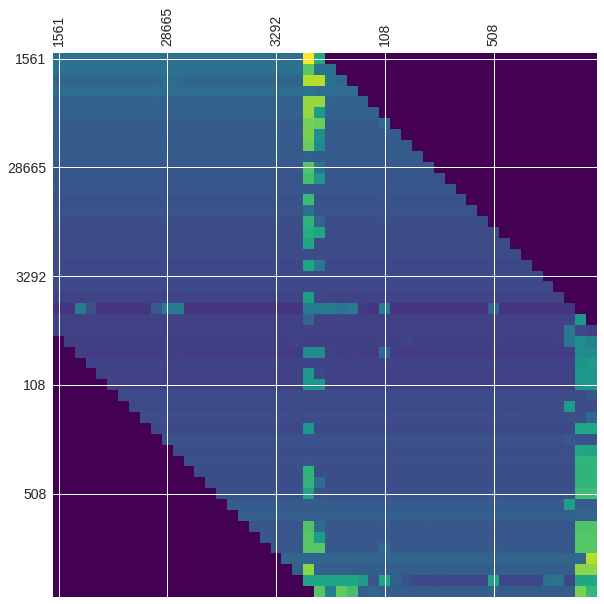

Attention 2


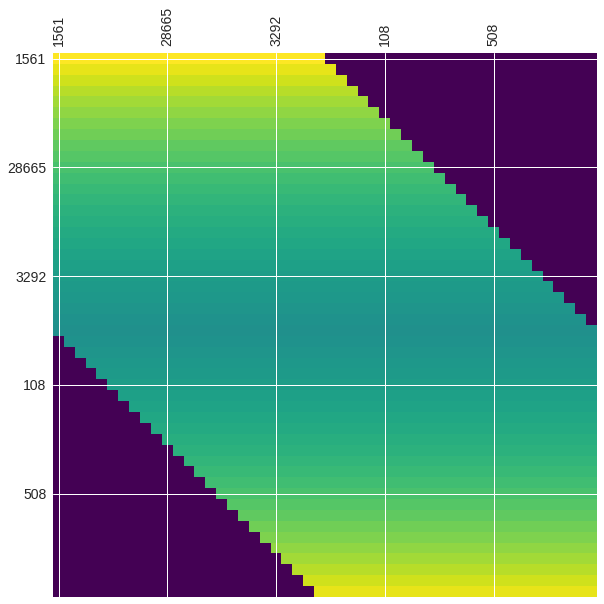

In [0]:
start_sequence = 150
seq_len = 50

def visualize_attention(model, start_sequence, seq_len):
  """ This is where we utilize the eager execution of Tensorflow 2.
  
  """
  test_input = np.array([generate])[:,start_sequence:start_sequence+seq_len]
  out = test_input

  for i, layer in enumerate(model.layers):
    out = layer(out)
    if i == 3 or i == 6:
      print("Attention {}".format(i//3))
      attention = out[1][0].numpy()
      trans_input = test_input[0].astype(str).tolist()
      plot_attention(attention, trans_input, trans_input)
      out = out[0]

visualize_attention(model, start_sequence, seq_len)

In [0]:
attention[30]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02222222, 0.02222222, 0.02222222, 0.02222222, 0.02222222,
       0.02222222, 0.02222222, 0.02222222, 0.02222222, 0.02222222,
       0.02222222, 0.02222222, 0.02222222, 0.02222222, 0.02222222,
       0.02222222, 0.02222222, 0.02222222, 0.02222222, 0.02222222,
       0.02222222, 0.02222222, 0.02222222, 0.02222222, 0.02222222,
       0.02222222, 0.02222222, 0.02222222, 0.02222222, 0.02222222,
       0.02222222, 0.02222222, 0.02222222, 0.02222222, 0.02222222,
       0.02222222, 0.02222222, 0.02222222, 0.02222222, 0.02222222,
       0.02222222, 0.02222222, 0.02222222, 0.02222222, 0.02222222],
      dtype=float32)